Cython
====

Cython is an "optimizing static compiler " that combines Python with C to generate optimized code. Since Cython is a superset of Python, all valid Python programs are also valid Cython programs. However, by providing hints and static typing, we can get much faster programs. Note that while `numba` often provides similar speedups with less work,, an advantage of Cython is that it is easy to distribute optimized Cython modules since they can be built with the standard Python `setup.py` script.

We have already seen how to use Cython to wrap C and C++ functions from existing libraries. Here we will see how to use Cython to speed up Python functions. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

### Resources

- [Cython documentation](http://docs.cython.org/index.html)
- [Cython: A guide for Python programmers](http://www.amazon.com/Cython-Kurt-W-Smith/dp/1491901551)

**Utility function for timing functions**

In [2]:
import time

In [3]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [4]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

Incremental improvements
----

Generally, we start with a pure Python function, run it through Cython with the annotate `-a` flag, and incrementally modify the code until the yellow parts are minimized.

How to build Cython modules
----

From [official docs](http://docs.cython.org/index.html)

Using Cython consists of these steps:

- Write a .pyx source file
- Run the Cython compiler to generate a C file
- Run a C compiler to generate a compiled library
- Run the Python interpreter and ask it to import the module

In the Jupyter notebook, we can use the `%%cython` cell magic to automate these steps.

In [5]:
%load_ext cython

#### Matrix multiplication example

In [6]:
def matrix_multiply(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [7]:
import numpy as np
u = np.random.random((10,20))
v = np.random.random((20,5))

In [8]:
res = np.zeros((u.shape[0], v.shape[1]))
matrix_multiply(u, v, res)

array([[ 3.11449823,  5.35977303,  5.48778181,  5.14085938,  4.54520686],
       [ 3.68374999,  4.67333347,  4.37704824,  4.61282881,  3.85293391],
       [ 4.01582061,  5.53693287,  5.23375753,  4.67309499,  4.59460048],
       [ 4.07493259,  4.63093078,  5.00670814,  4.92908673,  4.23099528],
       [ 3.56821364,  4.64831502,  3.89552072,  4.74094422,  3.83194289],
       [ 3.59114576,  4.14569789,  4.77227321,  4.45942977,  3.77867553],
       [ 5.17616931,  5.73851388,  5.6071998 ,  5.99414005,  5.01139514],
       [ 2.89575575,  4.00384915,  4.71317099,  4.75876412,  4.30115292],
       [ 4.08424318,  5.54013852,  5.29577668,  5.74588951,  4.45967311],
       [ 3.95142186,  5.68656356,  5.02933096,  5.7503449 ,  5.06054258]])

In [9]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply(u, v, res)

3 loops, best of 3: 653 µs per loop


### Using Cython annnotations to identify bottlenecks

In [10]:
%%cython -a

import numpy as np

def matrix_multiply1(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

### Using Cython cdefs and directives

In [11]:
%%cython -a

import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply1(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil:
        for i in range(m):
            for j in range(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [12]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply1(u, v, res)

3 loops, best of 3: 12.4 µs per loop


### Parallel execution with Cython

Will not work unless OpenMP is installed.

In [13]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply2(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil, parallel():
        for i in prange(m):
            for j in prange(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [14]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply2(u, v, res)

The slowest run took 112.92 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 90.2 µs per loop


In [15]:
import time

In [16]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color   

Mandelbrot created on CPU in 15.622738 s


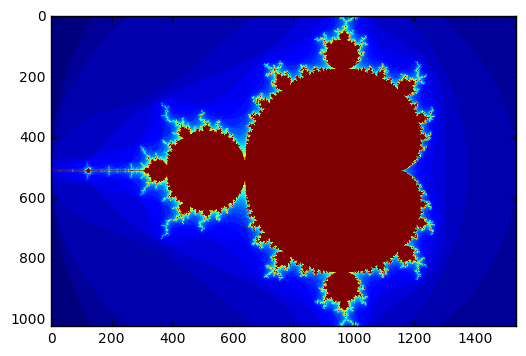

In [17]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

In [18]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

# color function for point at (x, y)
cdef unsigned char mandel_cython(double x, double y, int max_iters):
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(double xmin, double xmax, double ymin, double ymax, unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created on CPU in 0.462727 s


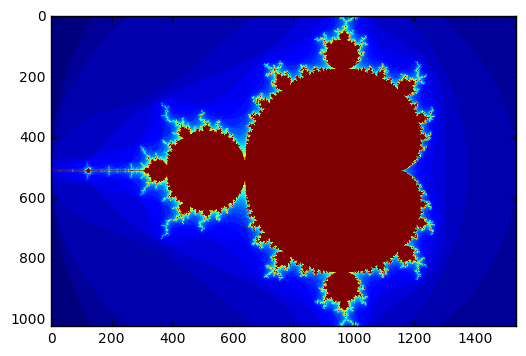

In [19]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass